In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/Github/SindyAutoencoders_project

/content/drive/My Drive/Colab Notebooks/Github/SindyAutoencoders_project


In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import os
from robi.example_LV import generate_lofka_volterra_data, get_lofka_volterra_data
from scipy.integrate import odeint, solve_ivp
from src.autoencoder import full_network
from src.training import create_feed_dictionary
from src.sindy_utils import sindy_simulate

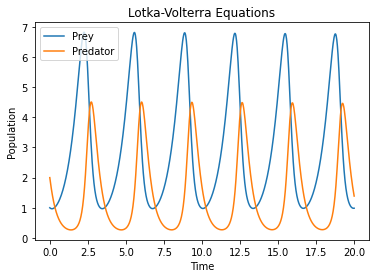

In [4]:
# Define the Lotka-Volterra equations
def lotka_volterra(t, y, a, b, c, d):
    u, v = y
    du = a*u - b*u*v
    dv = -c*v + d*u*v
    return [du, dv]

# u = population of the prey
# v = popolation of the predator

# Set the parameter values and initial conditions
a = 1.5         # birth rate of the prey
b = 1           # death rate of the prey due to predation
c = 3           # death rate of the predator in the absence of prey
d = 1           # conversion efficiency of the predator
y0 = [1, 2]

# Set the time range for simulation
t_start = 0
t_end = 20
t_eval = np.linspace(t_start, t_end, 1000)

# Solve the differential equations using solve_ivp
sol = solve_ivp(lotka_volterra, [t_start, t_end], y0, t_eval=t_eval, args=(a, b, c, d), method='LSODA')
# or method = RK45  which is the default one

# Plot the results
plt.plot(sol.t, sol.y[0], label='Prey')
plt.plot(sol.t, sol.y[1], label='Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Lotka-Volterra Equations')
plt.legend()
plt.show()

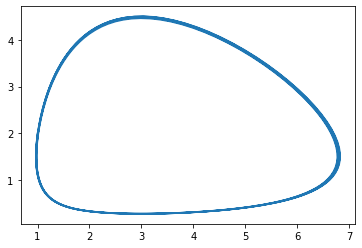

In [5]:
# ATTRACTOR for a specific initial condition (y0 = [1, 2])
plt.plot(sol.y[0], sol.y[1])

### Evaluate the obtained model (from the training) on a test set

In [6]:
# get the parameters obtained from the training of the sindy autoencoder NN
data_path = os.getcwd() + '/'
save_name = 'LV'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.compat.v1.placeholder(tf.float32, name='learning_rate')
saver = tf.compat.v1.train.Saver(var_list=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

In [7]:
t = np.arange(0,20,.01)
z0 = np.array([[1,2]])

test_data = generate_lofka_volterra_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/10,1/10]),
                            a=1.5, b=1., c=3., d=1.)
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['z'] = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz'] = test_data['dz'].reshape((-1,params['latent_dim']))

In [8]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

n_ics = 1
z_sim = np.zeros((n_ics, t.size, 2))
LV_sim = np.zeros(z_sim.shape)
for i in range(n_ics):
    z_sim[i] = sindy_simulate(test_set_results['z'][i*t.size], t,
                                     params['coefficient_mask']*test_set_results['sindy_coefficients'],
                                     params['poly_order'], params['include_sine'])
    LV_sim[i] = sindy_simulate(test_data['z'][i*t.size], t,
                                            test_data['sindy_coefficients'],
                                            params['poly_order'], params['include_sine'])

In [9]:
test_data['sindy_coefficients']

array([[ 0. ,  0. ],
       [ 1.5,  0. ],
       [ 0. , -3. ],
       [ 0. ,  0. ],
       [-1. ,  1. ],
       [ 0. ,  0. ]])

In [10]:
params['coefficient_mask']*test_set_results['sindy_coefficients']

array([[-0.       ,  0.       ],
       [ 0.       , -2.004414 ],
       [ 1.6791089,  0.       ],
       [ 0.8176815,  0.       ],
       [-0.       ,  0.       ],
       [-0.7407777,  0.       ]], dtype=float32)

In [11]:
test_set_results['sindy_coefficients']
#params

array([[-1.3471815e-04,  2.0818328e-04],
       [ 2.0132171e-05, -2.0044141e+00],
       [ 1.6791089e+00,  4.1300234e-05],
       [ 8.1768149e-01,  1.0293094e-04],
       [-7.7235774e-05,  2.4015954e-04],
       [-7.4077767e-01,  1.5811989e-04]], dtype=float32)

([], [])

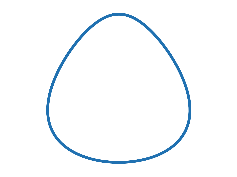

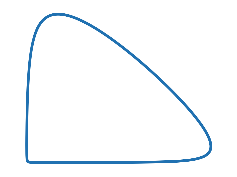

In [12]:
# PLOT THE ATTRACTOR IN THE PREDICTED CASE (with predicted coefficients) AND IN THE SIMULATED CASE (with true coefficients)
plt.figure(figsize=(4,3))
plt.plot(z_sim[:,:,0].T, z_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(4,3))
plt.plot(LV_sim[:,:,0].T, LV_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

<ipython-input-13-51e922b3085b>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)


(-99.95, 2098.95, -1.3449246764183045, 1.4716577410697937)

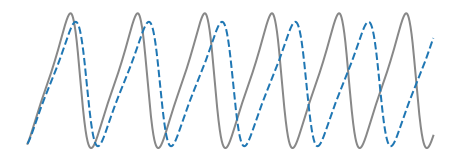

In [13]:
# plot the trajectory of the latent variable z(t) in the component of the prey (u) considering one initial condition
ic_idx = 0 

plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[ic_idx,:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

<ipython-input-14-04c0c6a78689>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,1], 'k', color='#888888', linewidth=2)


(-99.95, 2098.95, -1.6504989547782578, 1.174661571614165)

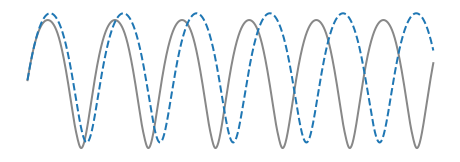

In [14]:
# plot the trajectory of the latent variable z(t) in the component of the predator (v) considering one initial condition
ic_idx = 0 

plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,1], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[ic_idx,:,1], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

In [15]:
test_data = get_lofka_volterra_data(100, noise_strength=1e-6)

In [16]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

In [17]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy relative error, z: %f' % sindy_dz_error)

Decoder relative error: 0.000005
Decoder relative SINDy error: 0.000260
SINDy relative error, z: 0.000395
